# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from copy import deepcopy
from bs4 import BeautifulSoup
from unicodedata import normalize as uni_normalize
from matplotlib import cm

# Working on HTML versions

## Parsing the HTML file
Let's first read the html file extracted from the REME PDF:

In [2]:
HTML_FILE = "docs/html_pages/rep_metiers-12.html"

In [3]:
with open(HTML_FILE, "r") as reme_html:
    full_html = reme_html.read()

In [4]:
soup = BeautifulSoup(full_html)

## Extracting all < p > elements

We'll begin by deleting all HTML tags that do not contain any human-readable text:

In [5]:
for tag in soup.find_all():
    if len(tag.get_text(strip=True)) == 0:
        tag.extract()

In [6]:
paragraphs = soup.find_all('p')

## Extracting the locations

In [7]:
def get_pos(p_object):
    """
    Retrieves the position of a <p> object from its style attribute.
    Returns a pair (top, left) in pixels.
    """
    top, left = re.findall('[0-9]+', p_object.attrs['style'])
    return int(top), int(left)

In [8]:
locations = [get_pos(par) for par in paragraphs]
# Map (top, left) --> <p> object
tops, lefts = [x for x, y in locations], [y for x, y in locations]

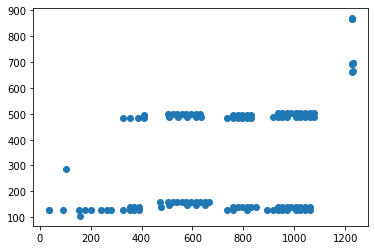

In [9]:
plt.scatter(tops, lefts)

## Clustering into paragraphs

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix

/home/clement/.conda/envs/raep/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
X = np.array([tops, lefts]).T
X.shape

(116, 2)

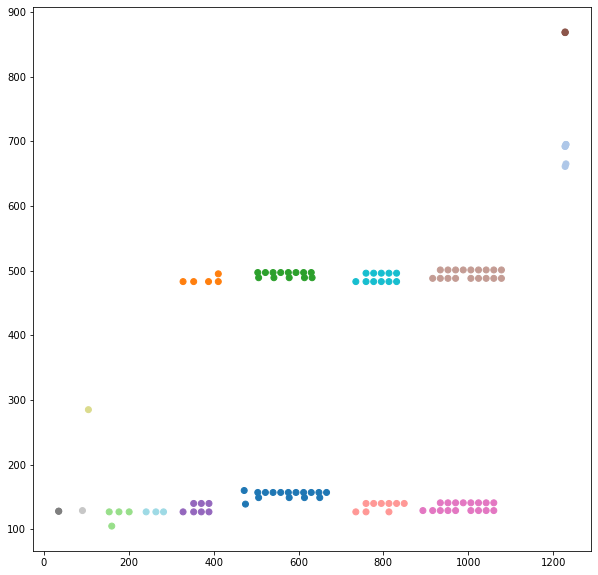

In [12]:
pred = AgglomerativeClustering(linkage="single", distance_threshold=37.5,
                               n_clusters=None,
                               affinity="l1").fit_predict(X)
plt.figure(figsize=(10, 10))
plt.scatter(tops, lefts, c=pred, cmap="tab20")

In [13]:
n_clusters = pred.max() + 1
clusters = [[] for _ in range(n_clusters)]
for i, prediction in enumerate(pred):
    clusters[prediction].append(paragraphs[i])

## Visualizing clusters
We'll now create a copy the HTML page upon which will be drawn shapes to delimit the clusters in the doc.

In [14]:
cmap = cm.get_cmap('tab20')

In [15]:
for k, cluster in enumerate(clusters):
    # Assign a color to the cluster
    color = cmap(k / n_clusters, bytes=True)
    # Assign that color as background to all elements in that cluster
    for elem in cluster:
        elem['style'] += ";background-color:rgba({}, {}, {}, 0.3);".format(*color)
        # We also add an artificial attribute to indicate the cluster
        elem['cluster'] = k

We'll save the new HTML file so that we can open it with a browser:

In [16]:
NEW_HTML_FILE = "visu_docs/page12.html"
with open(NEW_HTML_FILE, "w") as file:
    file.write(str(soup))